In [114]:
import yaml
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from INEGIpy import Indicadores
from sie_banxico import SIEBanxico  

In [115]:
def cargar_config(ruta_archivo='tokens.yaml'):
    """
    Carga los tokens de APIs desde un archivo YAML de configuración.
    
    Args:
        ruta_archivo (str): Ruta al archivo YAML (por defecto 'tokens.yaml')
        
    Returns:
        dict: Diccionario con la configuración cargada
    """
    try:
        with open(ruta_archivo, 'r') as archivo:
            config = yaml.safe_load(archivo)
        print("✅ Configuración cargada exitosamente")
        return config
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {ruta_archivo}")
        print(f"   Crea este archivo con la estructura adecuada para los tokens")
        return None
    except yaml.YAMLError as e:
        print(f"❌ Error al parsear el archivo YAML: {e}")
        return None

In [116]:
def obtener_inflacion_inegi(token_inegi, fecha_inicio=None, fecha_fin=None):
    """
    Obtiene datos de inflación (INPC) del INEGI utilizando directamente la clase Indicadores.
    
    Esta función consulta específicamente el indicador 910399 que corresponde al:
    "Índice Nacional de Precios al Consumidor (INPC) - Índice general - Variación porcentual mensual"
    Ruta temática: Indicadores económicos de coyuntura > Índices de precios > INPC. 
    Base segunda quincena Julio 2018. Actualización de Canasta y Ponderadores 2024 > 
    Mensual > Inflación mensual > Índice general
    
    Args:
        token_inegi (str): Token de acceso para la API de INEGI
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        
    Returns:
        DataFrame: DataFrame con los datos de inflación con columnas 'fecha' e 'inflacion_mensual'
    """
    try:
        # Si no se especifican fechas, establecemos valores predeterminados
        if not fecha_inicio:
            fecha_inicio = '2019-12-31'  # Por defecto, 5 años atrás
        if not fecha_fin:
            fecha_fin = '2024-12-31'  # Por defecto, hasta final de 2024
        
        # Inicializamos directamente la clase Indicadores con el token
        inegi_indicadores = Indicadores(token=token_inegi)
        
        # Usamos el método obtener_df de la clase Indicadores
        # Indicador 910399: INPC mensual, variación porcentual, índice general
        df_inflacion = inegi_indicadores.obtener_df(
            indicadores='910413',
            nombres='inflacion_mensual',
            inicio=fecha_inicio,
            fin=fecha_fin,
            banco='BIE'  # Especificamos explícitamente el banco
        )
        
        # Preparamos el dataframe para análisis posterior
        df_inflacion = df_inflacion.reset_index()
        df_inflacion.rename(columns={'fechas': 'fecha'}, inplace=True)
        
        # Ordenamos por fecha para asegurar coherencia en visualizaciones y análisis
        df_inflacion = df_inflacion.sort_values('fecha')
        
        print(f"✅ Datos de inflación obtenidos: {len(df_inflacion)} registros")
        print(f"   Período: {df_inflacion['fecha'].min().strftime('%Y-%m-%d')} a {df_inflacion['fecha'].max().strftime('%Y-%m-%d')}")
        
        return df_inflacion
    
    except Exception as e:
        print(f"❌ Error al obtener datos de inflación del INEGI: {e}")
        print("   Verifica el token y la conexión a internet.")
        return None

In [117]:
def obtener_tasa_interes_banxico(token, fecha_inicio=None, fecha_fin=None, frecuencia='mensual'):
    """
    Obtiene datos de la tasa de interés de CETES a 28 días directamente desde Banxico,
    y convierte los datos a frecuencia mensual si es necesario.
    
    Esta función consulta específicamente la serie SF43783 que corresponde a:
    "Tasas de interés de valores gubernamentales - Tasa de rendimiento 
    promedio mensual de CETES 28 días"
    
    Args:
        token (str): Token de la API de Banxico
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        frecuencia (str, optional): Frecuencia de datos ('diaria' o 'mensual')
        
    Returns:
        DataFrame: DataFrame con los datos de tasas de interés con columnas 'fecha' y 'tasa_cetes28'
    """
    # Si no se especifican fechas, tomamos los últimos tres años para tener datos suficientes
    if not fecha_inicio:
        fecha_inicio = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')
    if not fecha_fin:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')
    
    try:
        # Importamos la biblioteca SIEBanxico
        from sie_banxico import SIEBanxico
        
        # Inicializamos el cliente con el token y la serie SF43783 (Tasa de CETES 28 días)
        banxico = SIEBanxico(token=token, id_series=['SF43783'], language='es')
        
        # Obtenemos la serie en el rango de fechas especificado
        respuesta = banxico.get_timeseries_range(init_date=fecha_inicio, end_date=fecha_fin)
        
        # Extraemos los datos de la respuesta JSON
        datos = respuesta['bmx']['series'][0]['datos']
        
        # Convertimos a DataFrame
        df = pd.DataFrame(datos)
        
        # Procesamos el DataFrame
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
        df['dato'] = df['dato'].str.replace(',', '').astype(float)
        
        # Renombramos la columna de valores
        df = df.rename(columns={'dato': 'tasa_cetes28'})
        
        # La serie SF43783 normalmente ya viene en frecuencia mensual, pero verificamos
        # si hay múltiples registros por mes y aplicamos la conversión si es necesario
        
        # Creamos una columna de año-mes para verificar la frecuencia
        df['año_mes'] = df['fecha'].dt.to_period('M')
        
        # Contamos cuántos registros hay por mes
        registros_por_mes = df.groupby('año_mes').size()
        
        # Si hay meses con múltiples registros y se solicita frecuencia mensual, hacemos la conversión
        if registros_por_mes.max() > 1 and frecuencia.lower() == 'mensual':
            # Agrupamos por año-mes y calculamos el promedio
            df_mensual = df.groupby('año_mes').agg({
                'tasa_cetes28': 'mean'  # Promedio mensual de la tasa
            }).reset_index()
            
            # Convertimos la columna año_mes a fecha (primer día del mes)
            df_mensual['fecha'] = df_mensual['año_mes'].dt.to_timestamp()
            
            # Redondeamos los valores para mejor legibilidad
            df_mensual['tasa_cetes28'] = df_mensual['tasa_cetes28'].round(2)
            
            # Eliminamos la columna auxiliar y ordenamos por fecha
            df_mensual = df_mensual.drop(columns=['año_mes']).sort_values('fecha')
            
            print(f"✅ Datos de tasa de interés CETES 28 días (SF43783) convertidos a frecuencia mensual: {len(df_mensual)} registros")
            print(f"   Período: {df_mensual['fecha'].min().strftime('%Y-%m-%d')} a {df_mensual['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df_mensual
        else:
            # Si ya están en frecuencia mensual o se solicita la frecuencia original
            df = df.drop(columns=['año_mes']).sort_values('fecha')
            
            frecuencia_actual = "mensual" if registros_por_mes.max() <= 1 else "mayor a mensual"
            print(f"✅ Datos de tasa de interés CETES 28 días (SF43783) con frecuencia {frecuencia_actual}: {len(df)} registros")
            print(f"   Período: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df
    
    except ImportError:
        print("❌ Error: No se encontró la biblioteca sie_banxico.")
        print("   Por favor, instálala con: pip install sie_banxico")
        return None
    except Exception as e:
        print(f"❌ Error al obtener datos de Banxico: {e}")
        print("   Verifica que el token sea válido y que tengas conexión a internet.")
        return None

In [118]:
def obtener_tipo_cambio_banxico(token, fecha_inicio=None, fecha_fin=None, frecuencia='mensual'):
    """
    Obtiene el tipo de cambio FIX (SF43718) peso-dólar usando la biblioteca SIEBanxico,
    y convierte los datos a frecuencia mensual.
    
    Esta función consulta específicamente la serie SF43718 que corresponde al:
    "Tipo de cambio, pesos por dólar E.U.A.(Diaria) Tipo de cambio para solventar 
    obligaciones denominadas en dólares Fecha de determinación (FIX)"
    
    Args:
        token (str): Token de la API de Banxico
        fecha_inicio (str, optional): Fecha de inicio en formato 'YYYY-MM-DD'
        fecha_fin (str, optional): Fecha final en formato 'YYYY-MM-DD'
        frecuencia (str, optional): Frecuencia de datos ('diaria' o 'mensual')
        
    Returns:
        DataFrame: DataFrame con los datos de tipo de cambio con columnas 'fecha' y 'tipo_cambio'
    """
    # Si no se especifican fechas, tomamos los últimos tres años para tener datos suficientes
    # al convertir a frecuencia mensual
    if not fecha_inicio:
        fecha_inicio = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')
    if not fecha_fin:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')
    
    try:
        # Importamos la biblioteca SIEBanxico
        from sie_banxico import SIEBanxico
        
        # Inicializamos el cliente con el token y la serie SF43718 (Tipo de cambio FIX)
        banxico = SIEBanxico(token=token, id_series=['SF43718'], language='es')
        
        # Obtenemos la serie en el rango de fechas especificado
        respuesta = banxico.get_timeseries_range(init_date=fecha_inicio, end_date=fecha_fin)
        
        # Extraemos los datos de la respuesta JSON
        datos = respuesta['bmx']['series'][0]['datos']
        
        # Convertimos a DataFrame
        df = pd.DataFrame(datos)
        
        # Procesamos el DataFrame
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
        df['dato'] = df['dato'].str.replace(',', '').astype(float)
        
        # Renombramos la columna de valores
        df = df.rename(columns={'dato': 'tipo_cambio'})
        
        # Si se solicita frecuencia mensual, convertimos los datos diarios a promedios mensuales
        if frecuencia.lower() == 'mensual':
            # Creamos una columna de año-mes para agrupar
            df['año_mes'] = df['fecha'].dt.to_period('M')
            
            # Agrupamos por año-mes y calculamos el promedio
            df_mensual = df.groupby('año_mes').agg({
                'tipo_cambio': 'mean'  # Promedio mensual del tipo de cambio
            }).reset_index()
            
            # Convertimos la columna año_mes a fecha (primer día del mes)
            df_mensual['fecha'] = df_mensual['año_mes'].dt.to_timestamp()
            
            # Redondeamos los valores para mejor legibilidad
            df_mensual['tipo_cambio'] = df_mensual['tipo_cambio'].round(4)
            
            # Eliminamos la columna auxiliar y ordenamos por fecha
            df_mensual = df_mensual.drop(columns=['año_mes']).sort_values('fecha')
            
            print(f"✅ Datos de tipo de cambio FIX (SF43718) convertidos a frecuencia mensual: {len(df_mensual)} registros")
            print(f"   Período: {df_mensual['fecha'].min().strftime('%Y-%m-%d')} a {df_mensual['fecha'].max().strftime('%Y-%m-%d')}")
            
            return df_mensual
        
        # Si se mantiene la frecuencia diaria, retornamos los datos originales
        print(f"✅ Datos de tipo de cambio FIX (SF43718) con frecuencia diaria: {len(df)} registros")
        print(f"   Período: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
        
        return df
    
    except ImportError:
        print("❌ Error: No se encontró la biblioteca sie_banxico.")
        print("   Por favor, instálala con: pip install sie_banxico")
        return None
    except Exception as e:
        print(f"❌ Error al obtener datos de Banxico: {e}")
        print("   Verifica que el token sea válido y que tengas conexión a internet.")
        return None

In [119]:
def analizar_dataset(df, nombre_dataset):
    """
    Realiza un análisis exploratorio básico de un DataFrame, incluyendo:
    - Verificación de valores nulos
    - Estadísticas descriptivas
    - Distribución de los datos
    
    Args:
        df: DataFrame a analizar
        nombre_dataset: Nombre descriptivo del dataset para los encabezados
    """
    print(f"\n{'=' * 80}")
    print(f"ANÁLISIS EXPLORATORIO: {nombre_dataset}")
    print(f"{'=' * 80}")
    
    # 1. Información general del DataFrame
    print(f"\n📋 Información general:")
    print(f"  - Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"  - Período: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
    print(f"  - Columnas: {', '.join(df.columns.tolist())}")
    
    # 2. Verificación de valores nulos
    nulos_totales = df.isnull().sum().sum()
    if nulos_totales > 0:
        print(f"\n⚠️ Valores nulos encontrados: {nulos_totales}")
        print(f"  Distribución por columna:")
        for col in df.columns:
            nulos_col = df[col].isnull().sum()
            if nulos_col > 0:
                print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df)*100:.2f}%)")
    else:
        print(f"\n✅ No se encontraron valores nulos.")
    
    # 3. Estadísticas descriptivas para columnas numéricas
    columnas_numericas = df.select_dtypes(include=['number']).columns
    if len(columnas_numericas) > 0:
        print(f"\n📊 Estadísticas descriptivas:")
        estadisticas = df[columnas_numericas].describe().round(4)
        
        # Añadimos medidas adicionales de tendencia central
        for col in columnas_numericas:
            estadisticas.loc['mode', col] = df[col].mode().iloc[0] if not df[col].mode().empty else None
            estadisticas.loc['median', col] = df[col].median()
            estadisticas.loc['skewness', col] = df[col].skew().round(4)
            estadisticas.loc['kurtosis', col] = df[col].kurtosis().round(4)
        
        print(estadisticas)
        
        # 4. Rangos intercuartiles y detección de outliers
        print(f"\n🔍 Análisis de valores extremos:")
        for col in columnas_numericas:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            
            print(f"  - {col}:")
            print(f"    * Rango intercuartil (IQR): {IQR:.4f}")
            print(f"    * Límite inferior para outliers: {lower_bound:.4f}")
            print(f"    * Límite superior para outliers: {upper_bound:.4f}")
            print(f"    * Cantidad de posibles outliers detectados: {len(outliers)}")
            if len(outliers) > 0:
                print(f"    * Ejemplos de outliers: {outliers.head(3).values}")
    
    # 5. Verificación de frecuencia temporal
    if 'fecha' in df.columns:
        print(f"\n📅 Análisis de frecuencia temporal:")
        df_temp = df.copy()
        df_temp['mes'] = df_temp['fecha'].dt.month
        df_temp['año'] = df_temp['fecha'].dt.year
        
        # Conteo por año-mes
        conteo_por_mes = df_temp.groupby(['año', 'mes']).size()
        años_distintos = df_temp['año'].nunique()
        meses_distintos = conteo_por_mes.index.levels[1].nunique()
        
        print(f"  - Años distintos: {años_distintos}")
        print(f"  - Meses distintos por año (promedio): {meses_distintos/años_distintos:.1f}")
        
        # Verificamos si hay huecos en los datos
        bloques_continuos = 0
        for año in df_temp['año'].unique():
            meses_en_año = df_temp[df_temp['año'] == año]['mes'].unique()
            bloques_continuos += sum(1 for _ in groupby(sorted(meses_en_año), lambda x, c=count(): x-next(c)))
        
        if bloques_continuos > años_distintos:
            print(f"  ⚠️ Posibles discontinuidades temporales detectadas: {bloques_continuos} bloques continuos")
        else:
            print(f"  ✅ Series temporales continuas detectadas")
    
    print("\n")
    
    return None

# Importamos las bibliotecas necesarias para el análisis
from itertools import groupby, count

# Ejecutamos el análisis para cada dataset
analizar_dataset(df_tipo_cambio, "TIPO DE CAMBIO (FIX - SF43718)")
analizar_dataset(df_inflacion, "INFLACIÓN MENSUAL (INPC - 910399)")
analizar_dataset(df_tasas, "TASA DE INTERÉS (CETES 28 DÍAS - SF43783)")


ANÁLISIS EXPLORATORIO: TIPO DE CAMBIO (FIX - SF43718)

📋 Información general:
  - Dimensiones: 240 filas x 2 columnas
  - Período: 2004-12-01 a 2024-11-01
  - Columnas: tipo_cambio, fecha

✅ No se encontraron valores nulos.

📊 Estadísticas descriptivas:
          tipo_cambio
count       240.00000
mean         15.54370
std           3.71690
min          10.10950
25%          12.50290
50%          14.63300
75%          19.06680
max          24.26580
mode         18.98630
median       14.63305
skewness      0.17270
kurtosis     -1.41860

🔍 Análisis de valores extremos:
  - tipo_cambio:
    * Rango intercuartil (IQR): 6.5640
    * Límite inferior para outliers: 2.6569
    * Límite superior para outliers: 28.9128
    * Cantidad de posibles outliers detectados: 0

📅 Análisis de frecuencia temporal:
  - Años distintos: 21
  - Meses distintos por año (promedio): 0.6
  ✅ Series temporales continuas detectadas



ANÁLISIS EXPLORATORIO: INFLACIÓN MENSUAL (INPC - 910399)

📋 Información general:
 

In [120]:
# Cargamos la configuración 
config = cargar_config()
if not (config and 'banxico' in config and 'inegi' in config):
    print("❌ Error: Configuración incompleta. Verifica el archivo config.yaml")


# Obtenemos tokens 
token_banxico = config['banxico']['token']
token_inegi = config['inegi']['token']
inegi_indicadores = Indicadores(token=token_inegi)

✅ Configuración cargada exitosamente


In [121]:
# Definimos el rango de fechas (últimos diez años)
fecha_fin = '2024-12-01'  # Fecha fija: final del año 2024
fecha_inicio = '2004-12-01'  # Fecha fija: 5 años antes del fin (para tener un buen rango de datos)
    

print(f"\n📅 Periodo de análisis: {fecha_inicio} a {fecha_fin}")


📅 Periodo de análisis: 2004-12-01 a 2024-12-01


In [122]:
print("\n📊 Descargando datos económicos...")
df_tipo_cambio = obtener_tipo_cambio_banxico(token_banxico, fecha_inicio, fecha_fin)
df_inflacion = obtener_inflacion_inegi(token_inegi, fecha_inicio, fecha_fin)
df_tasas = obtener_tasa_interes_banxico(token_banxico, fecha_inicio, fecha_fin)


📊 Descargando datos económicos...
✅ Datos de tipo de cambio FIX (SF43718) convertidos a frecuencia mensual: 240 registros
   Período: 2004-12-01 a 2024-11-01


/opt/homebrew/Caskroom/miniconda/base/envs/analisis-economico/lib/python3.11/site-packages/INEGIpy/_indicadores.py:112: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.set_index(pd.to_datetime(df.fechas),inplace=True, drop=True)


✅ Datos de inflación obtenidos: 241 registros
   Período: 2004-12-01 a 2024-12-01
✅ Datos de tasa de interés CETES 28 días (SF43783) convertidos a frecuencia mensual: 240 registros
   Período: 2004-12-01 a 2024-11-01


In [123]:
df_tipo_cambio.head()

,tipo_cambio,fecha
0,11.2041,2004-12-01
1,11.2607,2005-01-01
2,11.1367,2005-02-01
3,11.1427,2005-03-01
4,11.1163,2005-04-01


In [124]:
df_inflacion.head()

,fecha,inflacion_mensual
0,2004-12-01,5.19
1,2005-01-01,0.00
2,2005-02-01,0.34
3,2005-03-01,0.79
4,2005-04-01,1.15


In [125]:
df_tasas.head()

,tasa_cetes28,fecha
0,8.93,2004-12-01
1,8.97,2005-01-01
2,9.47,2005-02-01
3,9.78,2005-03-01
4,10.01,2005-04-01


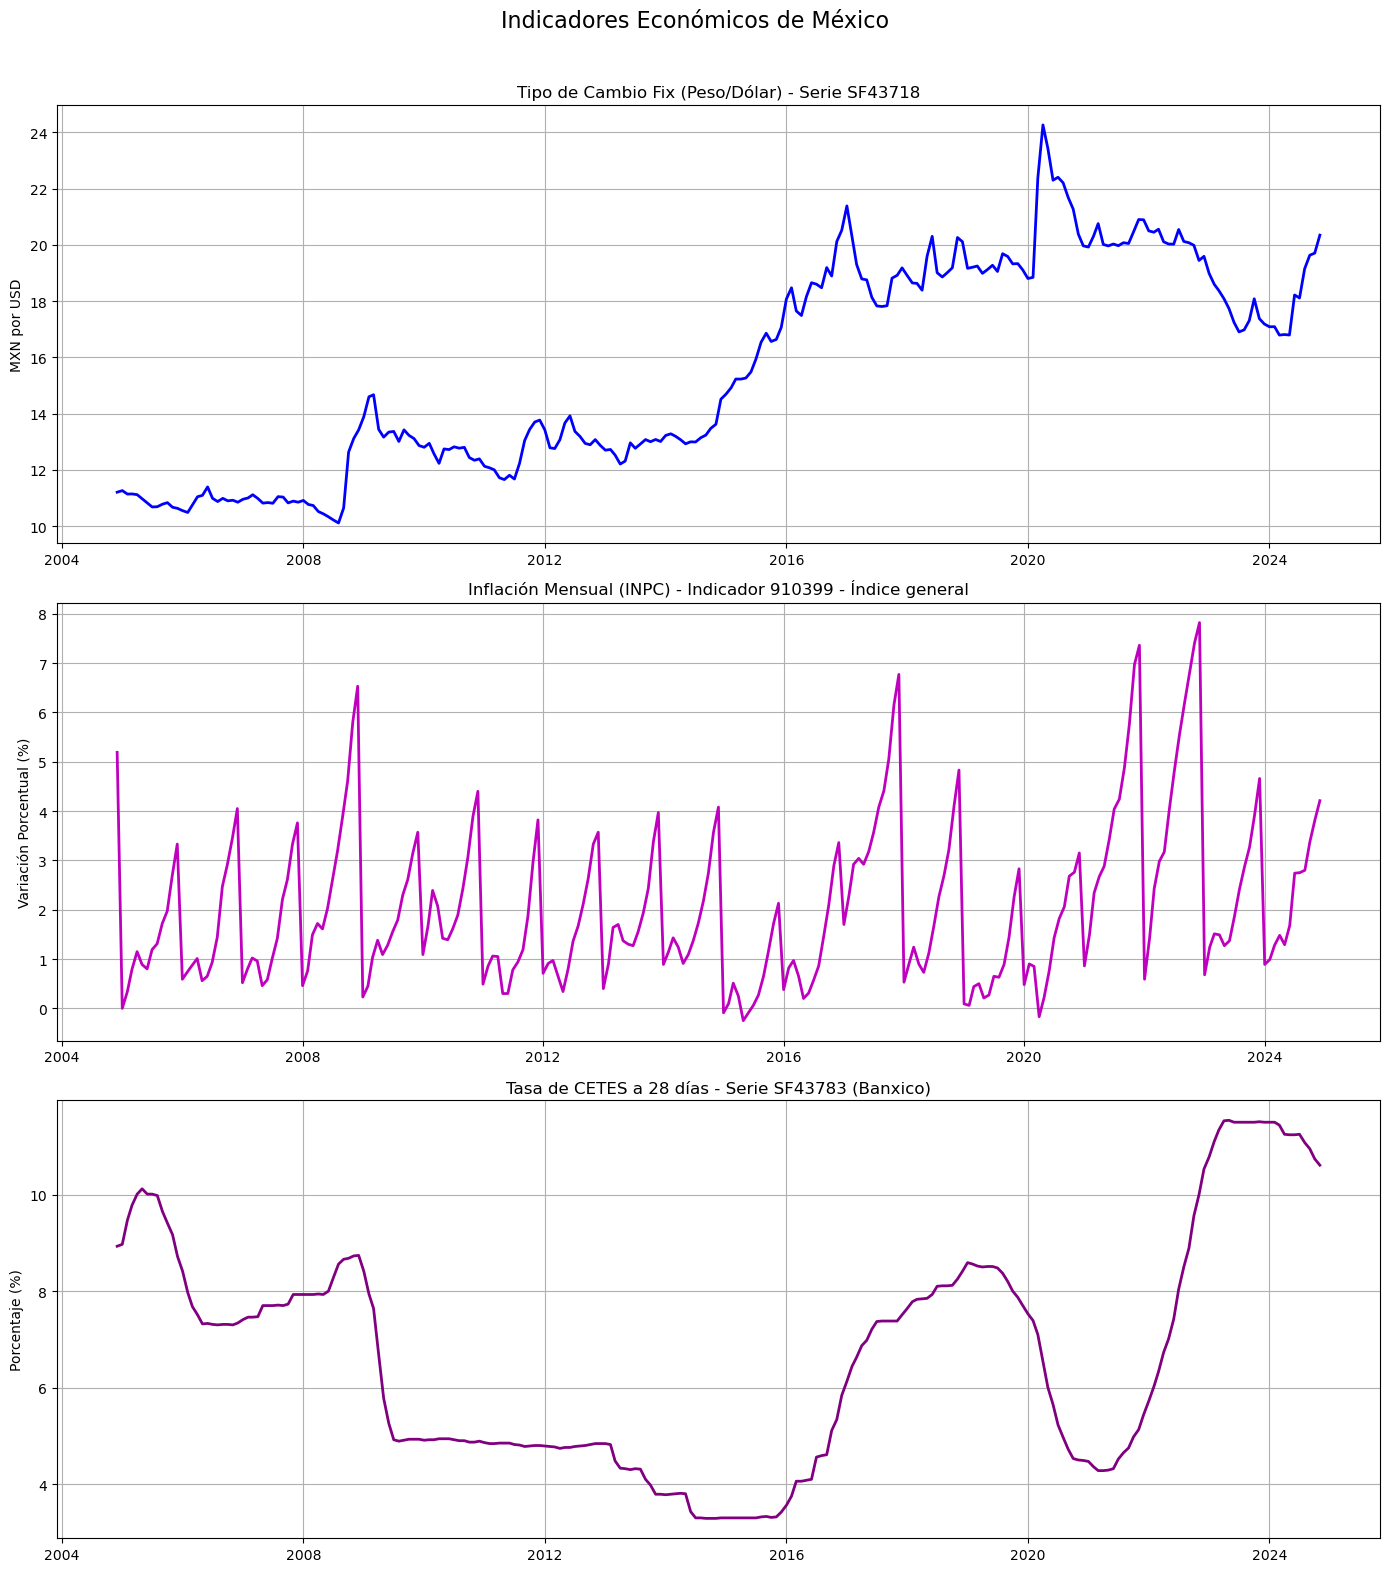

In [126]:
df_tc = df_tipo_cambio

# Configuramos el espacio para las gráficas
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=False)
fig.suptitle('Indicadores Económicos de México', fontsize=16)

# 1. Gráfica de Tipo de Cambio
axes[0].plot(df_tc['fecha'], df_tc['tipo_cambio'], 'b-', linewidth=2)
axes[0].set_title('Tipo de Cambio Fix (Peso/Dólar) - Serie SF43718')
axes[0].set_ylabel('MXN por USD')
axes[0].grid(True)

# 2. Gráfica de Inflación
# Solo tenemos inflación mensual
axes[1].plot(df_inflacion['fecha'], df_inflacion['inflacion_mensual'], 'm-', linewidth=2)
axes[1].set_title('Inflación Mensual (INPC) - Indicador 910399 - Índice general')
axes[1].set_ylabel('Variación Porcentual (%)')

axes[1].grid(True)

# 3. Gráfica de Tasas de Interés
axes[2].plot(df_tasas['fecha'], df_tasas['tasa_cetes28'], 'purple', linewidth=2)
axes[2].set_title('Tasa de CETES a 28 días - Serie SF43783 (Banxico)')
axes[2].set_ylabel('Porcentaje (%)')
axes[2].grid(True)

# Mejoramos la presentación
plt.tight_layout()
plt.subplots_adjust(top=0.92)
    

In [127]:
# Análisis exploratorio
analizar_dataset(df_tipo_cambio, "TIPO DE CAMBIO (FIX - SF43718)")
analizar_dataset(df_inflacion, "INFLACIÓN MENSUAL (INPC - 910399)")
analizar_dataset(df_tasas, "TASA DE INTERÉS (CETES 28 DÍAS - SF43783)")


ANÁLISIS EXPLORATORIO: TIPO DE CAMBIO (FIX - SF43718)

📋 Información general:
  - Dimensiones: 240 filas x 2 columnas
  - Período: 2004-12-01 a 2024-11-01
  - Columnas: tipo_cambio, fecha

✅ No se encontraron valores nulos.

📊 Estadísticas descriptivas:
          tipo_cambio
count       240.00000
mean         15.54370
std           3.71690
min          10.10950
25%          12.50290
50%          14.63300
75%          19.06680
max          24.26580
mode         18.98630
median       14.63305
skewness      0.17270
kurtosis     -1.41860

🔍 Análisis de valores extremos:
  - tipo_cambio:
    * Rango intercuartil (IQR): 6.5640
    * Límite inferior para outliers: 2.6569
    * Límite superior para outliers: 28.9128
    * Cantidad de posibles outliers detectados: 0

📅 Análisis de frecuencia temporal:
  - Años distintos: 21
  - Meses distintos por año (promedio): 0.6
  ✅ Series temporales continuas detectadas



ANÁLISIS EXPLORATORIO: INFLACIÓN MENSUAL (INPC - 910399)

📋 Información general:
 

In [128]:
if not os.path.exists('data'):
    os.makedirs('data')
    print("Created 'data' directory")

# Export each DataFrame to CSV in the data directory
df_tipo_cambio.to_csv('data/tipo_cambio.csv', index=False)
df_inflacion.to_csv('data/inflacion.csv', index=False)
df_tasas.to_csv('data/tasas_interes.csv', index=False)

# Print confirmation message
print(f"Files exported to 'data' directory:")
print(f"- data/tipo_cambio.csv: {len(df_tipo_cambio)} records")
print(f"- data/inflacion.csv: {len(df_inflacion)} records")
print(f"- data/tasas_interes.csv: {len(df_tasas)} records")

Created 'data' directory
Files exported to 'data' directory:
- data/tipo_cambio.csv: 240 records
- data/inflacion.csv: 241 records
- data/tasas_interes.csv: 240 records
